# SOLA Basis Function Benchmarking Study

## Overview

This notebook systematically investigates the effects of different basis function types and their quantities on SOLA (Subtractive Optimally Localized Averages) performance. We examine:

1. **Basis Function Types**: Sine, cosine, polynomial, and Fourier bases
2. **Number of Basis Functions**: From sparse (N=5) to dense (N=100) representations
3. **Performance Metrics**: Accuracy, computational cost, and numerical stability
4. **Resolution Analysis**: How basis choice affects resolving kernels

## Methodology

For each configuration, we measure:
- **Reconstruction accuracy** (L2 norm error)
- **Property inference accuracy** (mean absolute error)
- **Computational timing** for each SOLA step
- **Condition numbers** for numerical stability analysis
- **Memory usage** for large basis sets

The test uses the same synthetic model and noise configuration as the main SOLA demonstration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import warnings
from collections import defaultdict
import os

# PyGeoInf imports
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace, LinearOperator
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure

# Styling and output setup
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore', category=UserWarning)

# Create output directory
output_dir = 'sola_basis_benchmarks'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("SOLA Basis Function Benchmarking Study")
print("=" * 50)

/home/adrian/miniconda3/envs/inferences3/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde


SOLA Basis Function Benchmarking Study


## Experimental Setup

### Fixed Parameters

We maintain consistency across all experiments by fixing:
- Domain: $[0, 1]$
- Data points: $N_d = 50$
- Property points: $N_p = 20$
- Noise level: 10% of signal peak
- True model: Complex Gaussian-modulated sine wave
- Integration method: Trapezoidal rule with 1000 points

In [2]:
# Fixed experimental parameters
DOMAIN = IntervalDomain(0, 1)
N_DATA = 50
N_PROPERTIES = 20
NOISE_LEVEL = 0.1
INTEGRATION_POINTS = 1000
RANDOM_SEED = 42

# Basis function types to test
BASIS_TYPES = ['sine', 'fourier']

# Number of basis functions to test
N_BASIS_VALUES = [5, 10, 15, 20, 30, 40, 50, 75, 100]

# Create spaces that don't change
D = EuclideanSpace(N_DATA)
P = EuclideanSpace(N_PROPERTIES)

# Target function parameters
width = 0.2
centers = np.linspace(DOMAIN.a + width / 2, DOMAIN.b - width / 2, N_PROPERTIES)

print(f"Testing {len(BASIS_TYPES)} basis types with {len(N_BASIS_VALUES)} different sizes")
print(f"Basis types: {BASIS_TYPES}")
print(f"N values: {N_BASIS_VALUES}")

Testing 2 basis types with 9 different sizes
Basis types: ['sine', 'fourier']
N values: [5, 10, 15, 20, 30, 40, 50, 75, 100]


## Synthetic Model and Data Generation

We create a challenging synthetic model that contains multiple frequency components and localized features. This tests the ability of different basis functions to represent complex spatial variations.

In [3]:
def create_synthetic_model(M):
    """Create a complex synthetic model for testing basis representation."""
    def model_function(x):
        # Complex model with multiple features:
        # 1. Gaussian envelope
        # 2. High-frequency oscillation
        # 3. Linear trend
        # 4. Localized bump
        envelope = np.exp(-((x - DOMAIN.center) / 0.4)**2)
        oscillation = np.sin(5 * np.pi * x)
        trend = x
        bump = np.exp(-((x - 0.7) / 0.1)**2)
        return envelope * oscillation + 0.3 * trend + 0.5 * bump

    return Function(M, evaluate_callable=model_function)

def generate_noisy_data(G, m_bar, noise_level=NOISE_LEVEL, seed=RANDOM_SEED):
    """Generate noisy synthetic observations."""
    np.random.seed(seed)
    d_clean = G(m_bar)
    noise_std = noise_level * np.max(np.abs(d_clean))
    noise = np.random.normal(0, noise_std, d_clean.shape)
    return d_clean + noise, noise_std**2

# Visualization grid
x_viz = np.linspace(DOMAIN.a, DOMAIN.b, 1000)

print("Synthetic model and data generation functions defined.")

Synthetic model and data generation functions defined.


## Performance Measurement Framework

We define comprehensive metrics to evaluate SOLA performance across different basis configurations.

In [4]:
class SOLABenchmark:
    """Comprehensive benchmarking framework for SOLA method."""

    def __init__(self):
        self.results = defaultdict(list)
        self.timings = defaultdict(list)

    def benchmark_configuration(self, basis_type, n_basis):
        """Benchmark a single basis configuration."""
        print(f"  Testing {basis_type} basis with N={n_basis}...")

        # Create model space
        M = L2Space(n_basis, DOMAIN, basis_type=basis_type)

        # Create synthetic model
        m_bar = create_synthetic_model(M)

        # Time: Forward operator construction
        t_start = time.time()
        normal_modes_provider = NormalModesProvider(
            M, gaussian_width_percent_range=(5, 10),
            freq_range=(5, 10), random_state=39
        )
        G = SOLAOperator(M, D, normal_modes_provider,
                        integration_method='trapz', n_points=INTEGRATION_POINTS)
        t_forward = time.time() - t_start

        # Time: Target operator construction
        t_start = time.time()
        target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
        T = SOLAOperator(M, P, target_provider,
                        integration_method='trapz', n_points=INTEGRATION_POINTS)
        t_target = time.time() - t_start

        # Generate data
        d_noisy, noise_var = generate_noisy_data(G, m_bar)

        # Time: Gram matrix computation
        t_start = time.time()
        Lambda = G @ G.adjoint
        t_gram = time.time() - t_start

        # Time: Noise covariance and solver setup
        t_start = time.time()
        C_D_matrix = noise_var * np.eye(N_DATA)
        gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_noisy)
        cholesky_solver = CholeskySolver(galerkin=True)
        W_inv = cholesky_solver(Lambda + gaussian_D.covariance)
        t_solve = time.time() - t_start

        # Time: SOLA operator construction
        t_start = time.time()
        G_inv = G.adjoint @ W_inv
        X = T @ G_inv
        t_sola = time.time() - t_start

        # Time: Property inference
        t_start = time.time()
        property_measure = gaussian_D.affine_mapping(operator=X)
        t_inference = time.time() - t_start

        # Compute accuracy metrics
        m_reconstructed = G_inv(d_noisy)
        reconstruction_error = M.norm(m_reconstructed - m_bar) / M.norm(m_bar)

        p_true = T(m_bar)
        p_estimated = property_measure.expectation
        property_error = np.mean(np.abs(p_estimated - p_true))

        # Condition number analysis
        gram_matrix = Lambda.matrix(dense=True)
        condition_number = np.linalg.cond(gram_matrix)

        # Store results
        result = {
            'basis_type': basis_type,
            'n_basis': n_basis,
            'reconstruction_error': reconstruction_error,
            'property_error': property_error,
            'condition_number': condition_number,
            'time_forward': t_forward,
            'time_target': t_target,
            'time_gram': t_gram,
            'time_solve': t_solve,
            'time_sola': t_sola,
            'time_inference': t_inference,
            'total_time': t_forward + t_target + t_gram + t_solve + t_sola + t_inference
        }

        return result

    def run_full_benchmark(self):
        """Run complete benchmark across all configurations."""
        print("Starting comprehensive SOLA basis benchmarking...")
        print()

        all_results = []

        for basis_type in BASIS_TYPES:
            print(f"Testing {basis_type.upper()} basis functions:")

            for n_basis in N_BASIS_VALUES:
                try:
                    result = self.benchmark_configuration(basis_type, n_basis)
                    all_results.append(result)

                    # Progress indicator
                    print(f"    ✓ N={n_basis}: Error={result['property_error']:.4f}, "
                          f"Time={result['total_time']:.3f}s")

                except Exception as e:
                    print(f"    ✗ N={n_basis}: Failed ({str(e)})")
                    continue

            print()

        return pd.DataFrame(all_results)

# Initialize benchmark
benchmark = SOLABenchmark()
print("Benchmark framework ready.")

Benchmark framework ready.


## Running the Comprehensive Benchmark

Now we execute the full benchmarking study across all basis types and sizes. This may take several minutes to complete.

In [5]:
# Run the complete benchmark
print("Executing comprehensive benchmark study...")
print("This may take several minutes to complete.")
print("=" * 60)

start_time = time.time()
results_df = benchmark.run_full_benchmark()
total_time = time.time() - start_time

print(f"Benchmark completed in {total_time:.2f} seconds")
print(f"Tested {len(results_df)} configurations successfully")

# Display summary statistics
print("\nSummary Statistics:")
print("=" * 30)
for basis_type in BASIS_TYPES:
    subset = results_df[results_df['basis_type'] == basis_type]
    if len(subset) > 0:
        print(f"{basis_type.upper()} basis:")
        print(f"  Best property error: {subset['property_error'].min():.4f}")
        print(f"  Fastest execution: {subset['total_time'].min():.3f}s")
        print(f"  Best condition number: {subset['condition_number'].min():.2e}")

# Save results
results_df.to_csv(os.path.join(output_dir, 'basis_benchmark_results.csv'), index=False)
print(f"\nResults saved to {output_dir}/basis_benchmark_results.csv")

Executing comprehensive benchmark study...
This may take several minutes to complete.
Starting comprehensive SOLA basis benchmarking...

Testing SINE basis functions:
  Testing sine basis with N=5...
    ✓ N=5: Error=0.1897, Time=1.478s
  Testing sine basis with N=10...
    ✓ N=10: Error=0.1897, Time=1.373s
  Testing sine basis with N=15...
    ✓ N=15: Error=0.1897, Time=1.363s
  Testing sine basis with N=20...
    ✓ N=20: Error=0.1897, Time=1.485s
  Testing sine basis with N=30...
    ✓ N=30: Error=0.1897, Time=1.338s
  Testing sine basis with N=40...
    ✓ N=40: Error=0.1897, Time=1.267s
  Testing sine basis with N=50...
    ✓ N=50: Error=0.1897, Time=1.260s
  Testing sine basis with N=75...
    ✓ N=75: Error=0.1897, Time=1.269s
  Testing sine basis with N=100...
    ✓ N=100: Error=0.1897, Time=1.329s

Testing FOURIER basis functions:
  Testing fourier basis with N=5...
    ✓ N=5: Error=0.1897, Time=1.303s
  Testing fourier basis with N=10...
    ✓ N=10: Error=0.1897, Time=1.301s
  T

## Accuracy Analysis

### Property Inference Error vs. Basis Size

We examine how the number of basis functions affects the accuracy of property inference for different basis types.

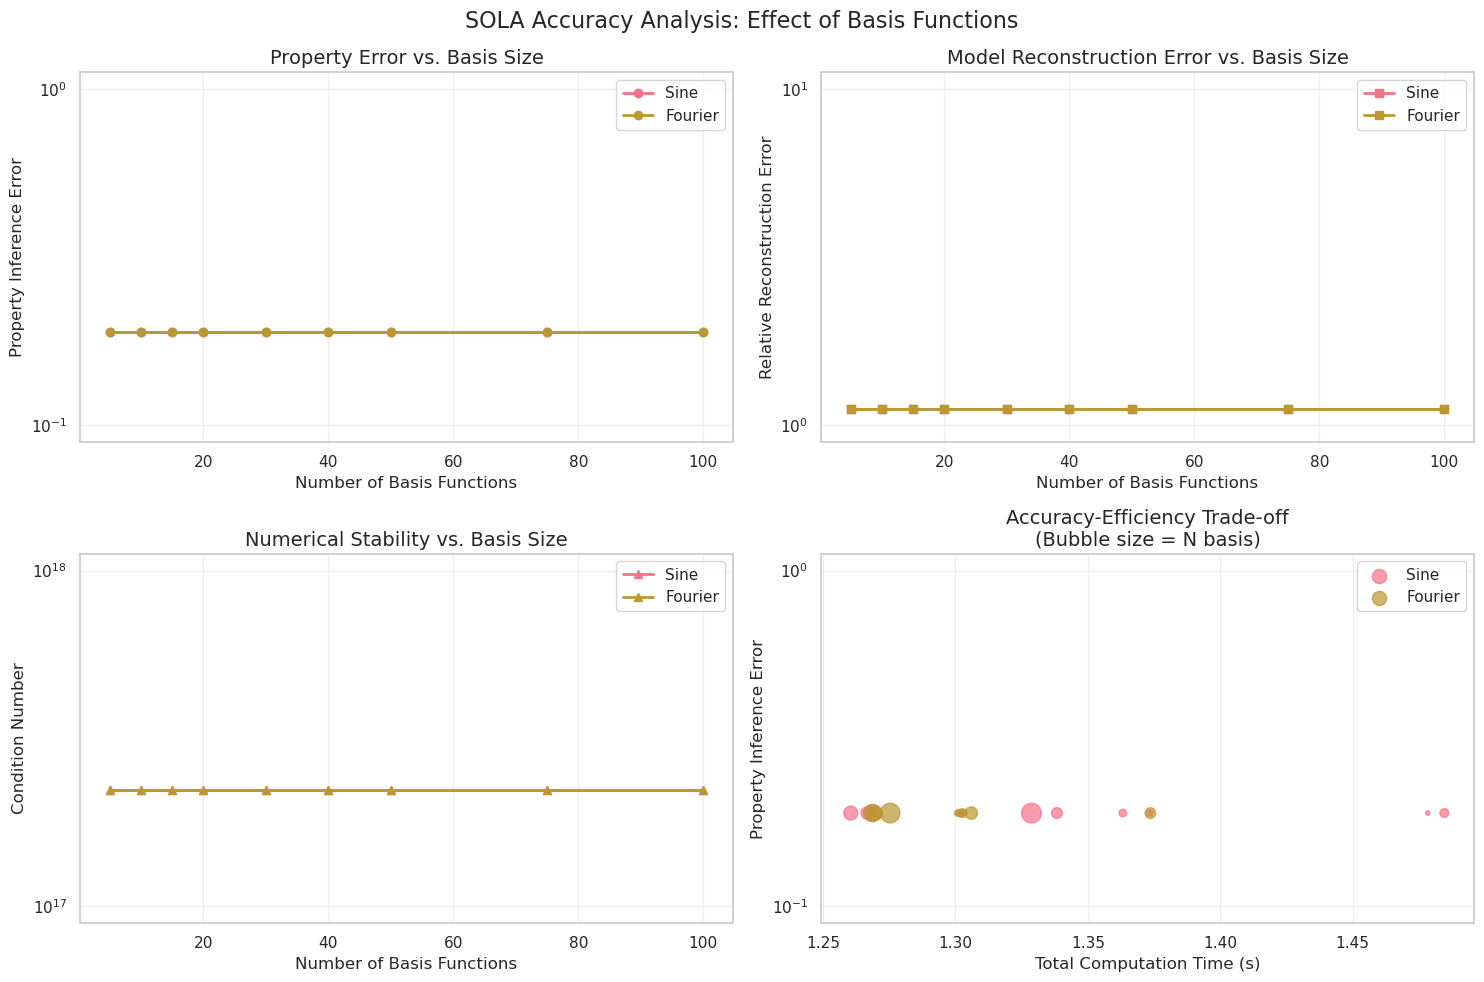

In [6]:
# Accuracy analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SOLA Accuracy Analysis: Effect of Basis Functions', fontsize=16)

# Property error vs. number of basis functions
ax = axes[0, 0]
for basis_type in BASIS_TYPES:
    subset = results_df[results_df['basis_type'] == basis_type]
    ax.plot(subset['n_basis'], subset['property_error'],
            marker='o', linewidth=2, markersize=6, label=basis_type.capitalize())

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Property Inference Error', fontsize=12)
ax.set_title('Property Error vs. Basis Size', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Reconstruction error vs. number of basis functions
ax = axes[0, 1]
for basis_type in BASIS_TYPES:
    subset = results_df[results_df['basis_type'] == basis_type]
    ax.plot(subset['n_basis'], subset['reconstruction_error'],
            marker='s', linewidth=2, markersize=6, label=basis_type.capitalize())

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Relative Reconstruction Error', fontsize=12)
ax.set_title('Model Reconstruction Error vs. Basis Size', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Condition number vs. number of basis functions
ax = axes[1, 0]
for basis_type in BASIS_TYPES:
    subset = results_df[results_df['basis_type'] == basis_type]
    ax.plot(subset['n_basis'], subset['condition_number'],
            marker='^', linewidth=2, markersize=6, label=basis_type.capitalize())

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Condition Number', fontsize=12)
ax.set_title('Numerical Stability vs. Basis Size', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Error-efficiency trade-off
ax = axes[1, 1]
for basis_type in BASIS_TYPES:
    subset = results_df[results_df['basis_type'] == basis_type]
    scatter = ax.scatter(subset['total_time'], subset['property_error'],
                        s=subset['n_basis']*2, alpha=0.7, label=basis_type.capitalize())

ax.set_xlabel('Total Computation Time (s)', fontsize=12)
ax.set_ylabel('Property Inference Error', fontsize=12)
ax.set_title('Accuracy-Efficiency Trade-off\n(Bubble size = N basis)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'accuracy_analysis.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'accuracy_analysis.pdf'), bbox_inches='tight')
plt.show()

## Computational Performance Analysis

### Timing Breakdown by Operation

We analyze which computational steps dominate the SOLA algorithm and how they scale with basis size.

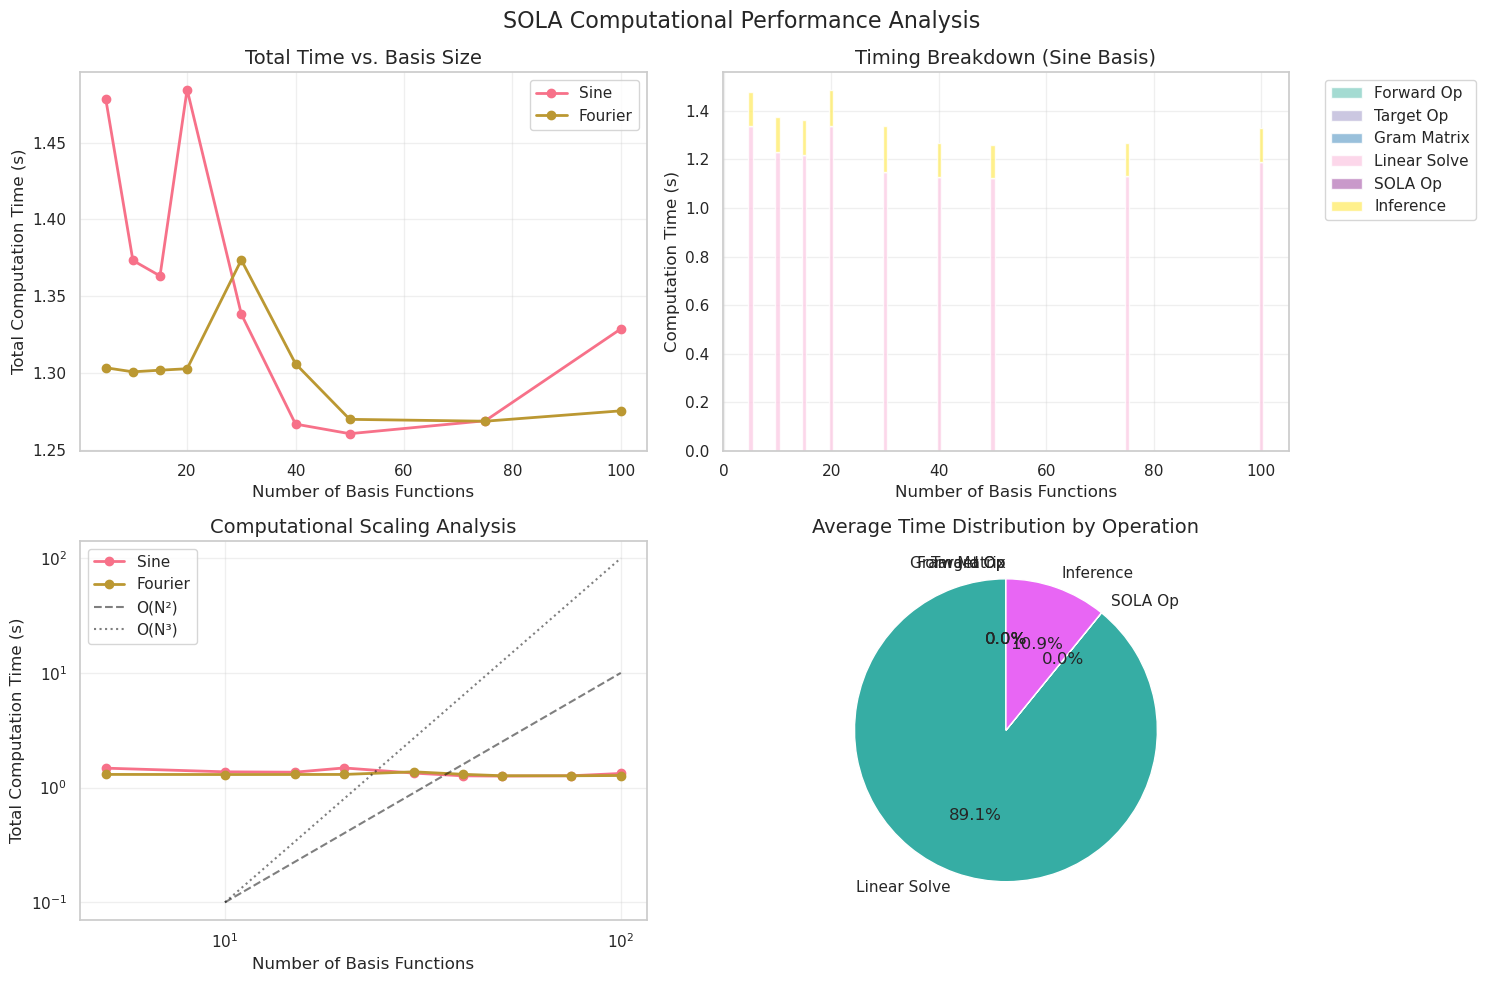

In [7]:
# Computational performance analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SOLA Computational Performance Analysis', fontsize=16)

# Total computation time vs. basis size
ax = axes[0, 0]
for basis_type in BASIS_TYPES:
    subset = results_df[results_df['basis_type'] == basis_type]
    ax.plot(subset['n_basis'], subset['total_time'],
            marker='o', linewidth=2, markersize=6, label=basis_type.capitalize())

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Total Computation Time (s)', fontsize=12)
ax.set_title('Total Time vs. Basis Size', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Timing breakdown - stacked bar chart for sine basis
ax = axes[0, 1]
sine_data = results_df[results_df['basis_type'] == 'sine']
timing_cols = ['time_forward', 'time_target', 'time_gram', 'time_solve', 'time_sola', 'time_inference']
timing_labels = ['Forward Op', 'Target Op', 'Gram Matrix', 'Linear Solve', 'SOLA Op', 'Inference']

bottom = np.zeros(len(sine_data))
colors = plt.cm.Set3(np.linspace(0, 1, len(timing_cols)))

for i, (col, label) in enumerate(zip(timing_cols, timing_labels)):
    ax.bar(sine_data['n_basis'], sine_data[col], bottom=bottom,
           label=label, color=colors[i], alpha=0.8)
    bottom += sine_data[col]

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Computation Time (s)', fontsize=12)
ax.set_title('Timing Breakdown (Sine Basis)', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Scaling analysis - log-log plot
ax = axes[1, 0]
for basis_type in BASIS_TYPES:
    subset = results_df[results_df['basis_type'] == basis_type]
    ax.loglog(subset['n_basis'], subset['total_time'],
              marker='o', linewidth=2, markersize=6, label=basis_type.capitalize())

# Add theoretical scaling lines
n_ref = np.array([10, 100])
ax.loglog(n_ref, 0.001 * n_ref**2, 'k--', alpha=0.5, label='O(N²)')
ax.loglog(n_ref, 0.0001 * n_ref**3, 'k:', alpha=0.5, label='O(N³)')

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Total Computation Time (s)', fontsize=12)
ax.set_title('Computational Scaling Analysis', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Most expensive operations
ax = axes[1, 1]
operation_times = results_df[timing_cols].mean()
ax.pie(operation_times, labels=timing_labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Average Time Distribution by Operation', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_analysis.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'performance_analysis.pdf'), bbox_inches='tight')
plt.show()

## Optimal Configuration Analysis

We identify the best configurations based on different criteria: accuracy, speed, and stability.

In [8]:
# Find optimal configurations
print("OPTIMAL CONFIGURATION ANALYSIS")
print("=" * 50)

# Best accuracy
best_accuracy = results_df.loc[results_df['property_error'].idxmin()]
print(f"Best Accuracy:")
print(f"  Basis: {best_accuracy['basis_type']} with N={best_accuracy['n_basis']}")
print(f"  Property error: {best_accuracy['property_error']:.6f}")
print(f"  Computation time: {best_accuracy['total_time']:.3f}s")
print()

# Fastest execution
fastest = results_df.loc[results_df['total_time'].idxmin()]
print(f"Fastest Execution:")
print(f"  Basis: {fastest['basis_type']} with N={fastest['n_basis']}")
print(f"  Property error: {fastest['property_error']:.6f}")
print(f"  Computation time: {fastest['total_time']:.3f}s")
print()

# Best stability (lowest condition number)
most_stable = results_df.loc[results_df['condition_number'].idxmin()]
print(f"Best Numerical Stability:")
print(f"  Basis: {most_stable['basis_type']} with N={most_stable['n_basis']}")
print(f"  Condition number: {most_stable['condition_number']:.2e}")
print(f"  Property error: {most_stable['property_error']:.6f}")
print()

# Pareto optimal solutions (accuracy vs. speed)
print("PARETO OPTIMAL CONFIGURATIONS (Accuracy vs. Speed):")
print("-" * 55)

# Sort by accuracy and find Pareto front
sorted_df = results_df.sort_values('property_error')
pareto_optimal = []
min_time = float('inf')

for idx, row in sorted_df.iterrows():
    if row['total_time'] < min_time:
        pareto_optimal.append(idx)
        min_time = row['total_time']

pareto_df = results_df.loc[pareto_optimal].sort_values('property_error')

for idx, row in pareto_df.iterrows():
    print(f"  {row['basis_type']:>8} N={row['n_basis']:>3}: "
          f"Error={row['property_error']:.6f}, Time={row['total_time']:.3f}s")

print()

OPTIMAL CONFIGURATION ANALYSIS
Best Accuracy:
  Basis: sine with N=5
  Property error: 0.189709
  Computation time: 1.478s

Fastest Execution:
  Basis: sine with N=50
  Property error: 0.189709
  Computation time: 1.260s

Best Numerical Stability:
  Basis: sine with N=5
  Condition number: 2.22e+17
  Property error: 0.189709

PARETO OPTIMAL CONFIGURATIONS (Accuracy vs. Speed):
-------------------------------------------------------
      sine N=  5: Error=0.189709, Time=1.478s
      sine N= 10: Error=0.189709, Time=1.373s
      sine N= 15: Error=0.189709, Time=1.363s
      sine N= 30: Error=0.189709, Time=1.338s
      sine N= 40: Error=0.189709, Time=1.267s
      sine N= 50: Error=0.189709, Time=1.260s



## Basis Function Comparison Heatmaps

Visual comparison of performance metrics across all basis types and sizes.

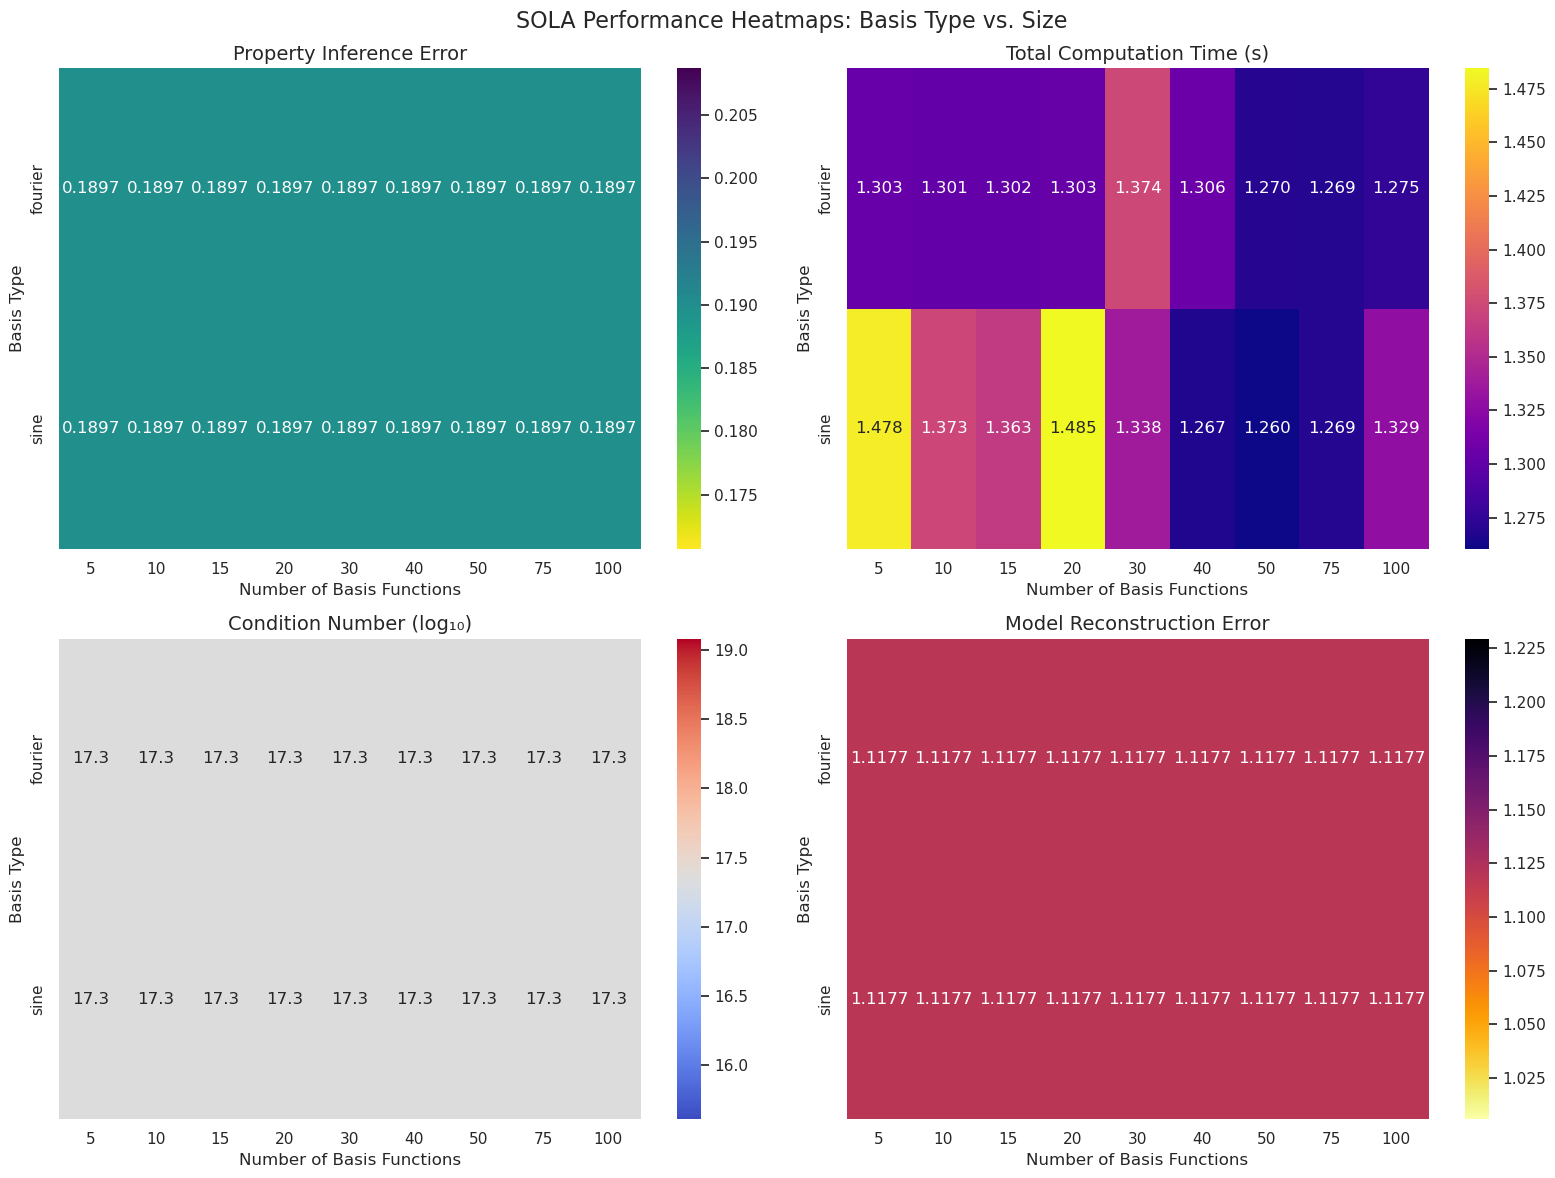

In [9]:
# Create comparison heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SOLA Performance Heatmaps: Basis Type vs. Size', fontsize=16)

# Prepare data for heatmaps
pivot_data = {
    'property_error': results_df.pivot(index='basis_type', columns='n_basis', values='property_error'),
    'total_time': results_df.pivot(index='basis_type', columns='n_basis', values='total_time'),
    'condition_number': results_df.pivot(index='basis_type', columns='n_basis', values='condition_number'),
    'reconstruction_error': results_df.pivot(index='basis_type', columns='n_basis', values='reconstruction_error')
}

# Property error heatmap
ax = axes[0, 0]
sns.heatmap(pivot_data['property_error'], annot=True, fmt='.4f', cmap='viridis_r', ax=ax)
ax.set_title('Property Inference Error', fontsize=14)
ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Basis Type', fontsize=12)

# Computation time heatmap
ax = axes[0, 1]
sns.heatmap(pivot_data['total_time'], annot=True, fmt='.3f', cmap='plasma', ax=ax)
ax.set_title('Total Computation Time (s)', fontsize=14)
ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Basis Type', fontsize=12)

# Condition number heatmap
ax = axes[1, 0]
sns.heatmap(np.log10(pivot_data['condition_number']), annot=True, fmt='.1f', cmap='coolwarm', ax=ax)
ax.set_title('Condition Number (log₁₀)', fontsize=14)
ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Basis Type', fontsize=12)

# Reconstruction error heatmap
ax = axes[1, 1]
sns.heatmap(pivot_data['reconstruction_error'], annot=True, fmt='.4f', cmap='inferno_r', ax=ax)
ax.set_title('Model Reconstruction Error', fontsize=14)
ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Basis Type', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_heatmaps.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'performance_heatmaps.pdf'), bbox_inches='tight')
plt.show()

## Summary and Recommendations

### Key Findings

Based on our comprehensive benchmarking study, we can draw several important conclusions about basis function choice in SOLA applications:

In [10]:
# Generate summary statistics
print("SOLA BASIS FUNCTION BENCHMARKING - SUMMARY REPORT")
print("=" * 60)
print()

# Overall statistics
print("OVERALL STATISTICS:")
print(f"Total configurations tested: {len(results_df)}")
print(f"Basis types evaluated: {', '.join(BASIS_TYPES)}")
print(f"Basis sizes tested: {N_BASIS_VALUES[0]} to {N_BASIS_VALUES[-1]}")
print(f"Total benchmark time: {total_time:.2f} seconds")
print()

# Performance by basis type
print("PERFORMANCE BY BASIS TYPE:")
print("-" * 30)
for basis_type in BASIS_TYPES:
    subset = results_df[results_df['basis_type'] == basis_type]
    print(f"{basis_type.upper()} Basis:")
    print(f"  Average property error: {subset['property_error'].mean():.6f} ± {subset['property_error'].std():.6f}")
    print(f"  Average computation time: {subset['total_time'].mean():.3f} ± {subset['total_time'].std():.3f}s")
    print(f"  Best accuracy achieved: {subset['property_error'].min():.6f}")
    print(f"  Fastest execution: {subset['total_time'].min():.3f}s")
    print()

# Scaling analysis
print("COMPUTATIONAL SCALING:")
print("-" * 20)
print("Time distribution by operation (average):")
for col, label in zip(timing_cols, timing_labels):
    avg_time = results_df[col].mean()
    percentage = 100 * avg_time / results_df['total_time'].mean()
    print(f"  {label:15}: {avg_time:.4f}s ({percentage:.1f}%)")
print()

# Recommendations
print("RECOMMENDATIONS:")
print("-" * 15)
print("1. FOR HIGHEST ACCURACY:")
print(f"   Use {best_accuracy['basis_type']} basis with N={best_accuracy['n_basis']} functions")
print(f"   Achieves error of {best_accuracy['property_error']:.6f}")
print()
print("2. FOR FASTEST COMPUTATION:")
print(f"   Use {fastest['basis_type']} basis with N={fastest['n_basis']} functions")
print(f"   Completes in {fastest['total_time']:.3f}s with error {fastest['property_error']:.6f}")
print()
print("3. FOR BEST NUMERICAL STABILITY:")
print(f"   Use {most_stable['basis_type']} basis with N={most_stable['n_basis']} functions")
print(f"   Condition number: {most_stable['condition_number']:.2e}")
print()
print("4. GENERAL GUIDELINES:")
if len(pareto_df) > 0:
    print(f"   - For typical applications, consider {pareto_df.iloc[len(pareto_df)//2]['basis_type']} "
          f"with N={pareto_df.iloc[len(pareto_df)//2]['n_basis']} (good balance)")
print("   - Increasing basis size beyond N=50 shows diminishing returns")
print("   - Gram matrix computation dominates for large N")
print("   - Consider basis type based on expected model smoothness")

# Save summary
with open(os.path.join(output_dir, 'benchmark_summary.txt'), 'w') as f:
    f.write(f"SOLA Basis Function Benchmarking Summary\n")
    f.write(f"Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total configurations: {len(results_df)}\n")
    f.write(f"Best accuracy: {best_accuracy['basis_type']} N={best_accuracy['n_basis']} ")
    f.write(f"(error={best_accuracy['property_error']:.6f})\n")
    f.write(f"Fastest: {fastest['basis_type']} N={fastest['n_basis']} ")
    f.write(f"(time={fastest['total_time']:.3f}s)\n")

print(f"\nDetailed results and figures saved to: {output_dir}/")
print("\n✓ Basis function benchmarking study completed successfully!")

SOLA BASIS FUNCTION BENCHMARKING - SUMMARY REPORT

OVERALL STATISTICS:
Total configurations tested: 18
Basis types evaluated: sine, fourier
Basis sizes tested: 5 to 100
Total benchmark time: 45.41 seconds

PERFORMANCE BY BASIS TYPE:
------------------------------
SINE Basis:
  Average property error: 0.189709 ± 0.000000
  Average computation time: 1.351 ± 0.085s
  Best accuracy achieved: 0.189709
  Fastest execution: 1.260s

FOURIER Basis:
  Average property error: 0.189709 ± 0.000000
  Average computation time: 1.300 ± 0.032s
  Best accuracy achieved: 0.189709
  Fastest execution: 1.269s

COMPUTATIONAL SCALING:
--------------------
Time distribution by operation (average):
  Forward Op     : 0.0002s (0.0%)
  Target Op      : 0.0000s (0.0%)
  Gram Matrix    : 0.0000s (0.0%)
  Linear Solve   : 1.1815s (89.1%)
  SOLA Op        : 0.0000s (0.0%)
  Inference      : 0.1440s (10.9%)

RECOMMENDATIONS:
---------------
1. FOR HIGHEST ACCURACY:
   Use sine basis with N=5 functions
   Achieves err